In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import ppscore as pps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
from datetime import timedelta
from datetime import datetime
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer
import math




In [2]:
excel_file_path = 'budgetusd.xlsx'
sheet_name = "Rooms Revenue"

df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
df
# Load the Excel file into a pandas DataFrame


,Date,Percentage Rooms Occ %,Holidays Local,Seasonality,Holidays North,Local Rainy Season,International Flights,Marketing,Average Room Rate,Number of Rooms,Rooms Revenue
0,2022-01,0.61,3,High,7,No,1,62.111111,75,9,13136.888889
1,2022-02,0.62,1,High,0,No,1,62.111111,75,9,11430.527778
2,2022-03,0.39,0,High,0,No,1,99.305556,75,9,9742.611111
3,2022-04,0.70,5,High,0,No,1,246.055556,75,9,15043.805556
4,2022-05,0.47,1,Low,0,Medium,1,144.920389,75,9,8546.169167
5,2022-06,0.33,0,Low,0,Medium,1,118.458222,75,9,7171.419167
6,2022-07,0.67,3,Medium,20,Medium,1,46.761375,75,9,15864.973889
7,2022-08,0.49,2,Medium,10,Medium,1,149.967917,77,9,11925.820833
8,2022-09,0.51,3,Medium,0,Yes,1,170.240833,77,9,13738.026667
9,2022-10,0.40,0,Low,0,Yes,1,176.074631,77,9,7765.725450


In [3]:
# This function will remove decimal points

def round_up_numeric(value):
    if pd.notnull(value) and isinstance(value, (int, float)):
        return math.ceil(value * 100) / 100
    return value

df =  df.applymap(round_up_numeric)

In [4]:
# Define replacements for multiple columns
column_replacements = {
    'Local Rainy Season': {"No": 0, "Medium": 1, "Yes": 2},
    'Seasonality': {"Low": 0, "Medium": 1, "High": 2}
}

# Map values in the specified columns
for col, replacements in column_replacements.items():
    df[col] = df[col].replace(replacements)


In [5]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)


In [6]:
df

,Percentage Rooms Occ %,Holidays Local,Seasonality,Holidays North,Local Rainy Season,International Flights,Marketing,Average Room Rate,Number of Rooms,Rooms Revenue
Date,,,,,,,,,,
2022-01-01,0.61,3.0,2,7.0,0,1.0,62.12,75.0,9.0,13136.89
2022-02-01,0.62,1.0,2,0.0,0,1.0,62.12,75.0,9.0,11430.53
2022-03-01,0.39,0.0,2,0.0,0,1.0,99.31,75.0,9.0,9742.62
2022-04-01,0.70,5.0,2,0.0,0,1.0,246.06,75.0,9.0,15043.81
2022-05-01,0.47,1.0,0,0.0,1,1.0,144.93,75.0,9.0,8546.17
2022-06-01,0.33,0.0,0,0.0,1,1.0,118.46,75.0,9.0,7171.42
2022-07-01,0.67,3.0,1,20.0,1,1.0,46.77,75.0,9.0,15864.98
2022-08-01,0.49,2.0,1,10.0,1,1.0,149.97,77.0,9.0,11925.83
2022-09-01,0.51,3.0,1,0.0,2,1.0,170.25,77.0,9.0,13738.03


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(['Rooms Revenue'], axis=1),
                                        df['Rooms Revenue'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (19, 9) (19,) 
* Test set: (5, 9) (5,)


In [8]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(AdaBoostRegressor(random_state=101))),
        ("model", AdaBoostRegressor(random_state=101)),
])

    return pipeline
pipeline_random_forest_reg()  

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=AdaBoostRegressor(random_state=101))),
                ('model', AdaBoostRegressor(random_state=101))])

In [9]:
pipeline = pipeline_random_forest_reg()
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=AdaBoostRegressor(random_state=101))),
                ('model', AdaBoostRegressor(random_state=101))])

In [10]:
def feature_importance_tree_based_models(model, columns):
    """ Gets the mode, and the columns used to train the model
        we use the model.feature_importanes_ and columns to make a DataFrame that shows 
        the importance of each feature and then we print the features name and its relative 
        importance order, followed by a barplot indicating the importance
        """ 
    # Create DataFrame to display feature importance
    df_feature_importance = pd.DataFrame(data={
        'Features': columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    best_features = df_feature_importance['Features'].to_list()

    # Print the most important features and plot the feature importance
    print(f"* These are the {len(best_features)} most important features in descending order. The model was trained on them:")
    print(df_feature_importance['Features'].to_list())

    df_feature_importance.plot(kind='bar', x='Features', y='Importance')
    plt.show()

* These are the 2 most important features in descending order. The model was trained on them:
['Percentage Rooms Occ %', 'Marketing']


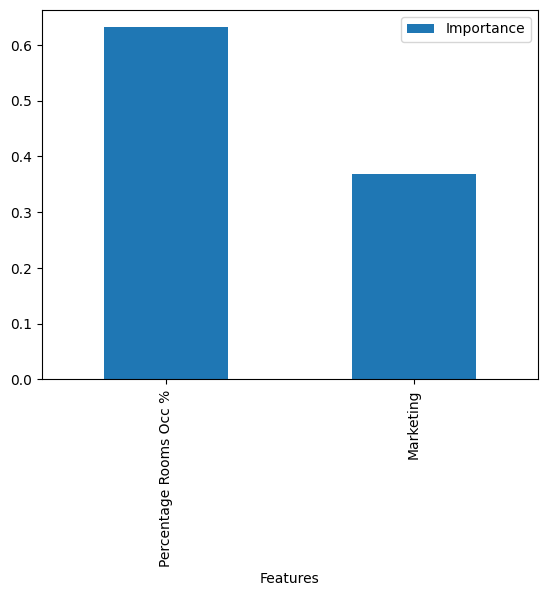

In [11]:
feature_importance_tree_based_models(model = pipeline['model'],
                                     columns = X_train.columns[pipeline['feature_selection'].get_support()])

In [12]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


Model Evaluation
* Train Set
R2 Score: 0.976
Mean Absolute Error: 405.743
Mean Squared Error: 336933.017
Root Mean Squared Error: 580.459


* Test Set
R2 Score: 0.741
Mean Absolute Error: 1761.757
Mean Squared Error: 4673341.32
Root Mean Squared Error: 2161.791




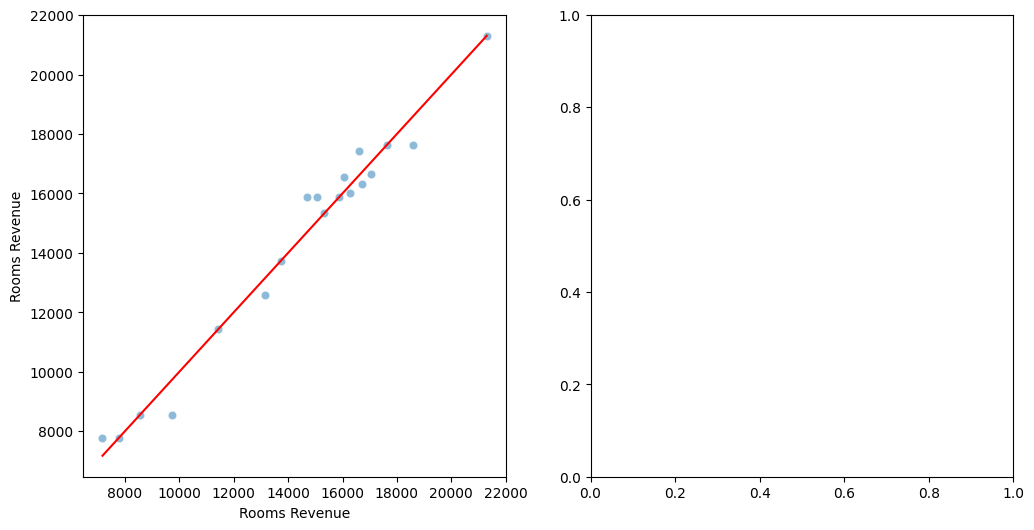

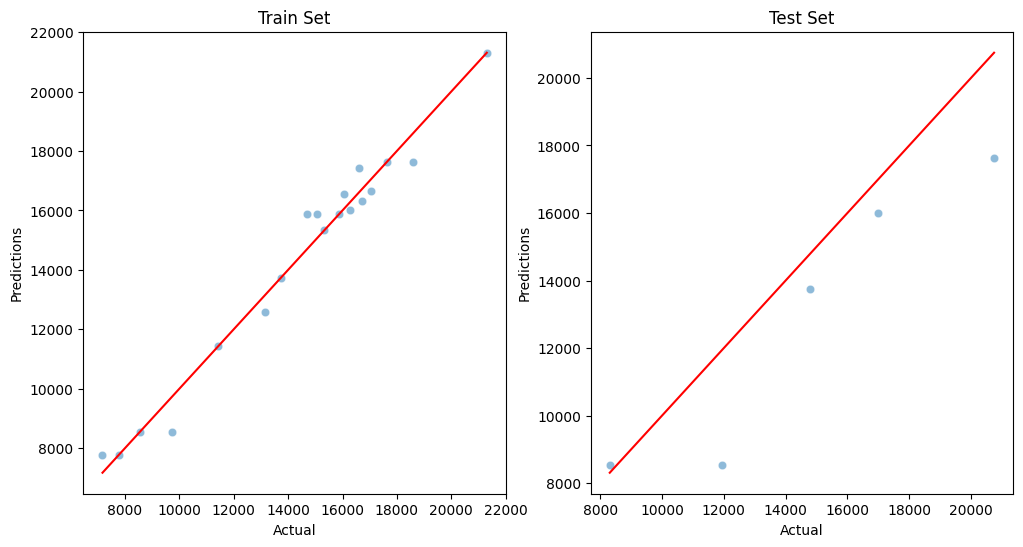

In [13]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


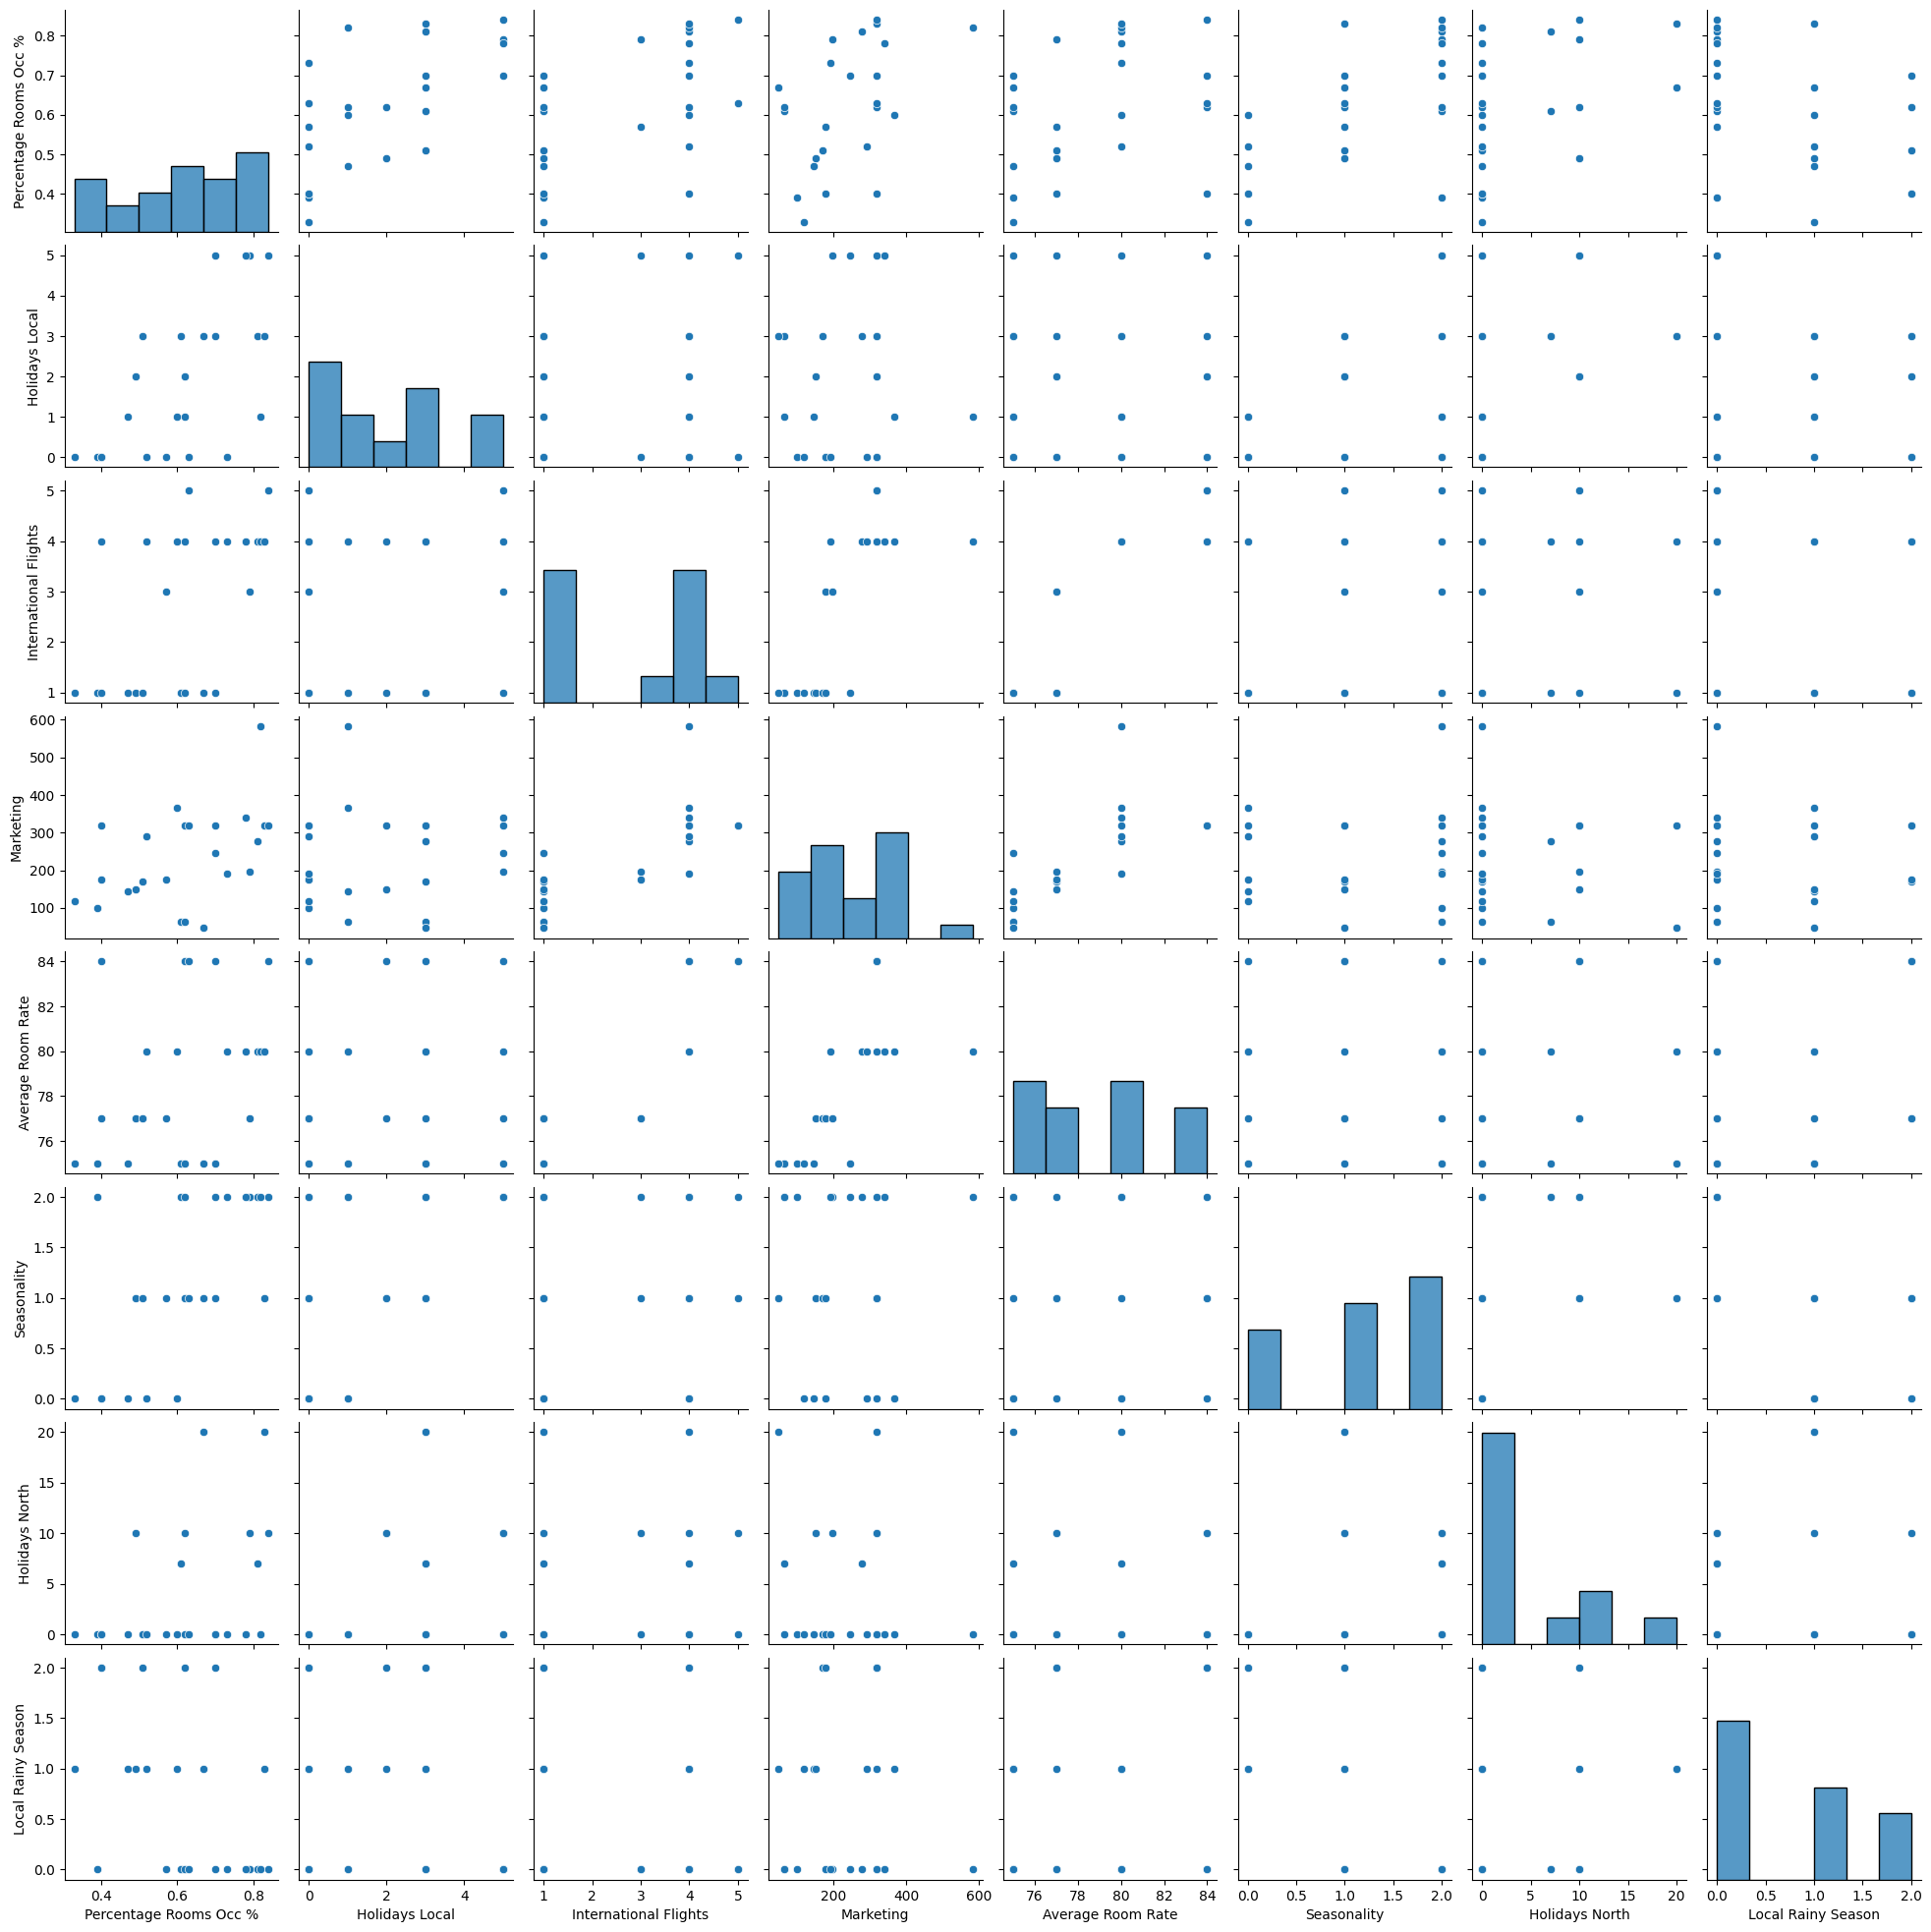

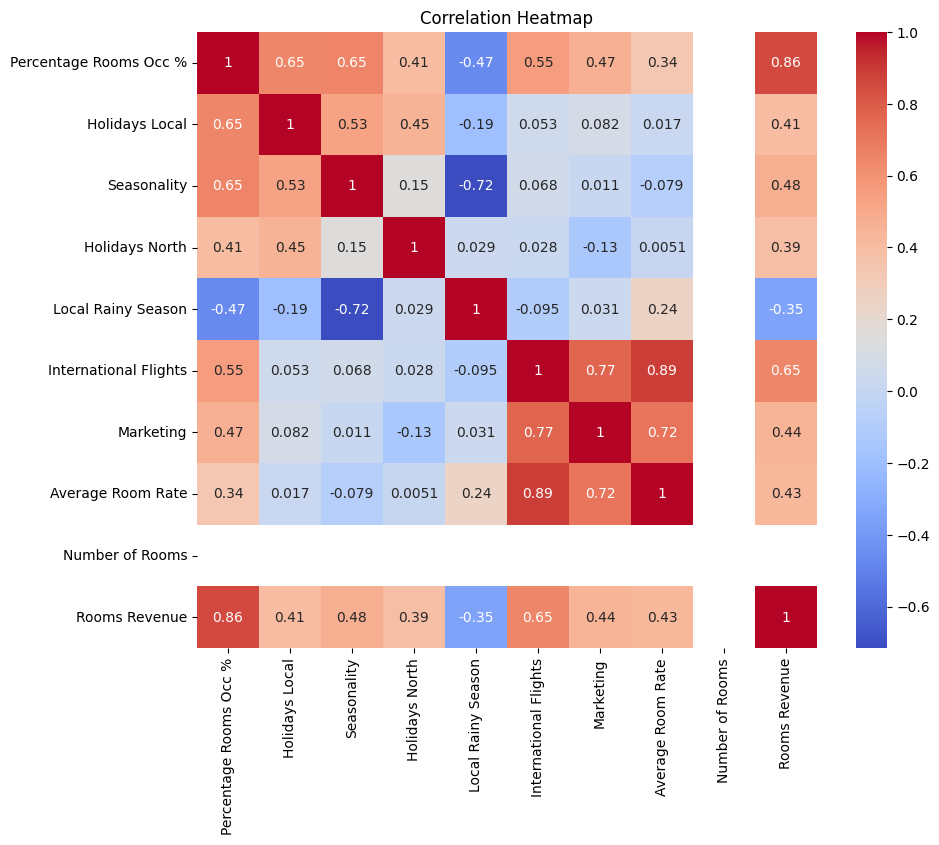

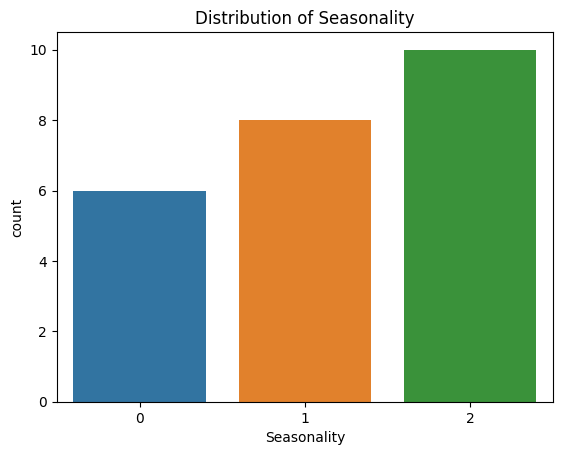

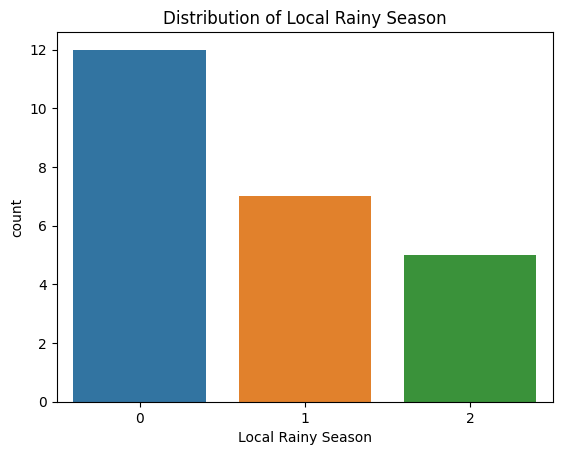

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plots for numerical variables 	
sns.pairplot(df, vars=['Percentage Rooms Occ %', 'Holidays Local', 'International Flights', 'Marketing', 'Average Room Rate', 
'Seasonality', 'Holidays North', 'Local Rainy Season',  ])
plt.show()

# Heatmap for numerical variable correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Bar plots for categorical variables
categorical_cols = ['Seasonality', 'Local Rainy Season']
for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()


### Correlation and PPS Analysis

In [15]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [16]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)


PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%   max
ppscore   90.0  0.071  0.166  0.0  0.0  0.0  0.032  0.74




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



/tmp/ipykernel_810/240643758.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


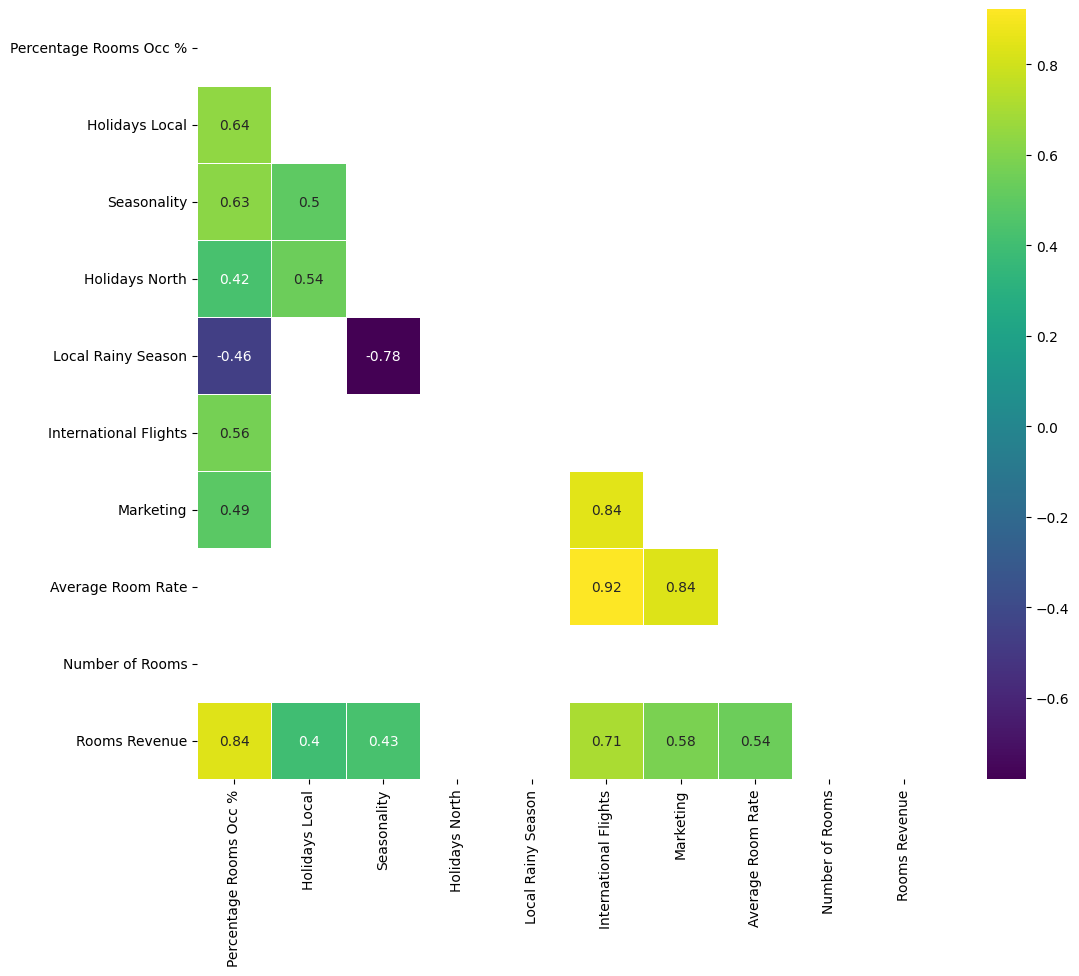



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



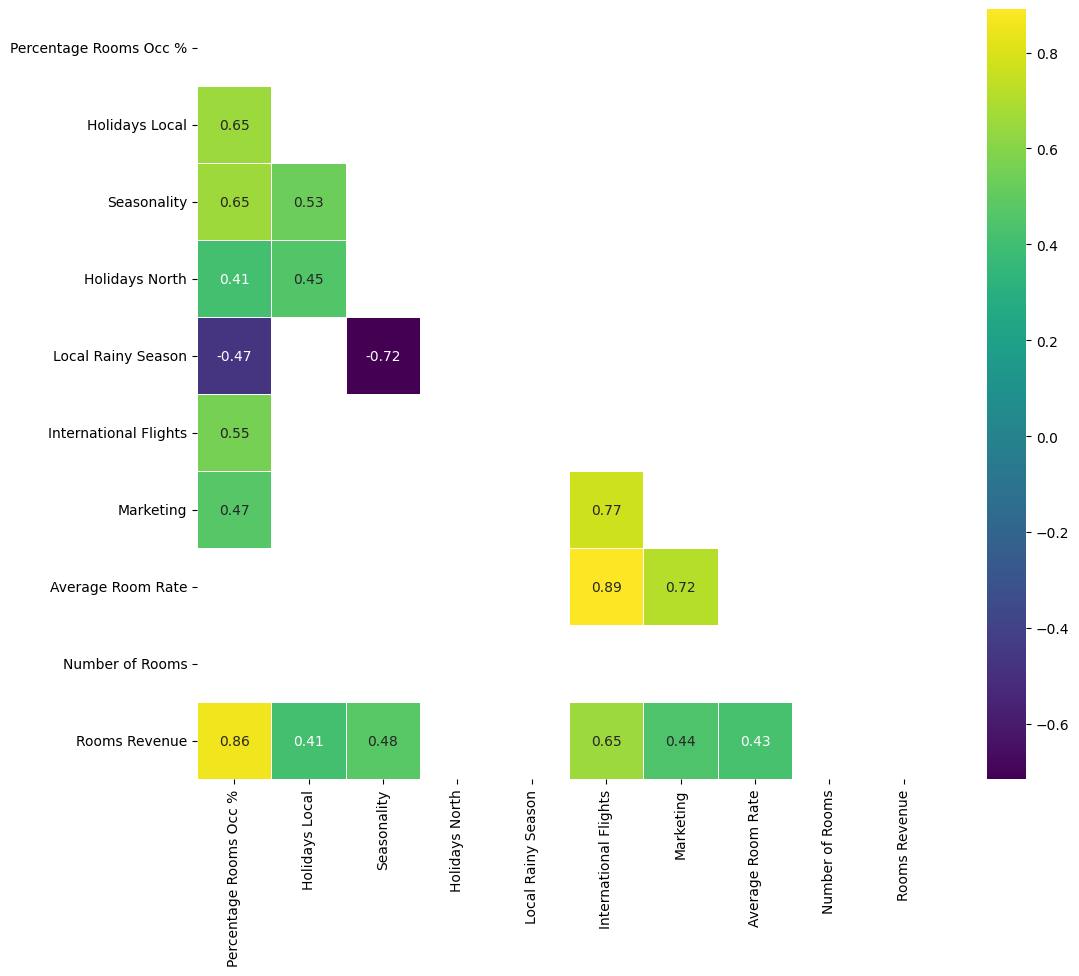



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



/tmp/ipykernel_810/240643758.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


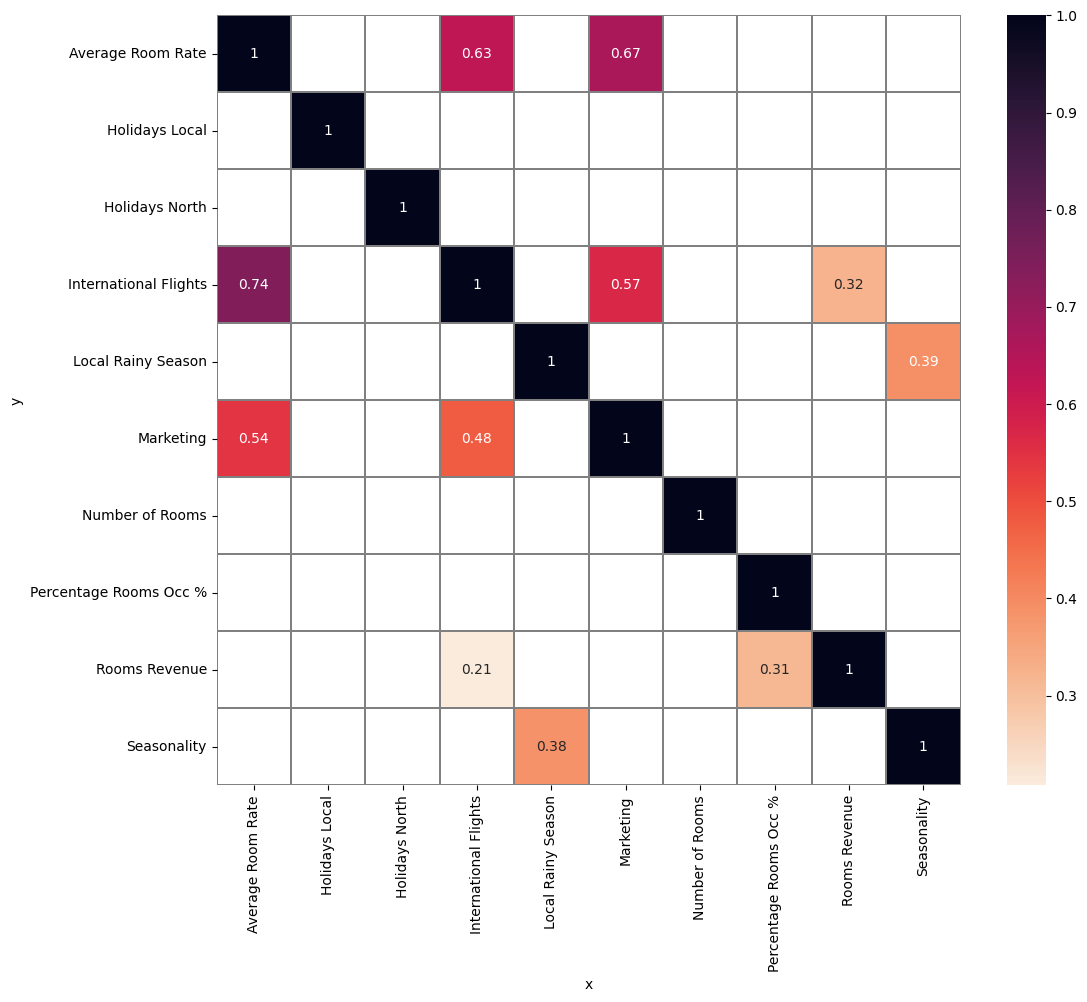

In [17]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

In [18]:
from feature_engine.selection import SmartCorrelatedSelection

# Define the list of input variables (excluding the target variable)
input_features = [
    'Percentage Rooms Occ %',
    'Holidays Local',
    'Seasonality',
    'Holidays North',
    'Local Rainy Season',
    'International Flights',
    'Marketing',
    'Average Room Rate'
]

# Create the SmartCorrelatedSelection object with the input features
corr_sel = SmartCorrelatedSelection(variables=input_features, method="spearman", threshold=0.5, selection_method="variance")

# Fit the selector to your dataset
corr_sel.fit(X_train, y_train)  # Replace X_train and y_train with your data


SmartCorrelatedSelection(method='spearman', selection_method='variance',
                         threshold=0.5,
                         variables=['Percentage Rooms Occ %', 'Holidays Local',
                                    'Seasonality', 'Holidays North',
                                    'Local Rainy Season',
                                    'International Flights', 'Marketing',
                                    'Average Room Rate'])

In [19]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.8, selection_method="variance")
corr_sel

SmartCorrelatedSelection(method='spearman', selection_method='variance')

In [20]:
corr_sel.fit_transform(df)
corr_sel.correlated_feature_sets_

[{'Percentage Rooms Occ %', 'Rooms Revenue'},
 {'Average Room Rate', 'International Flights', 'Marketing'}]

In [21]:
corr_sel.features_to_drop_


['Percentage Rooms Occ %', 'International Flights', 'Average Room Rate']

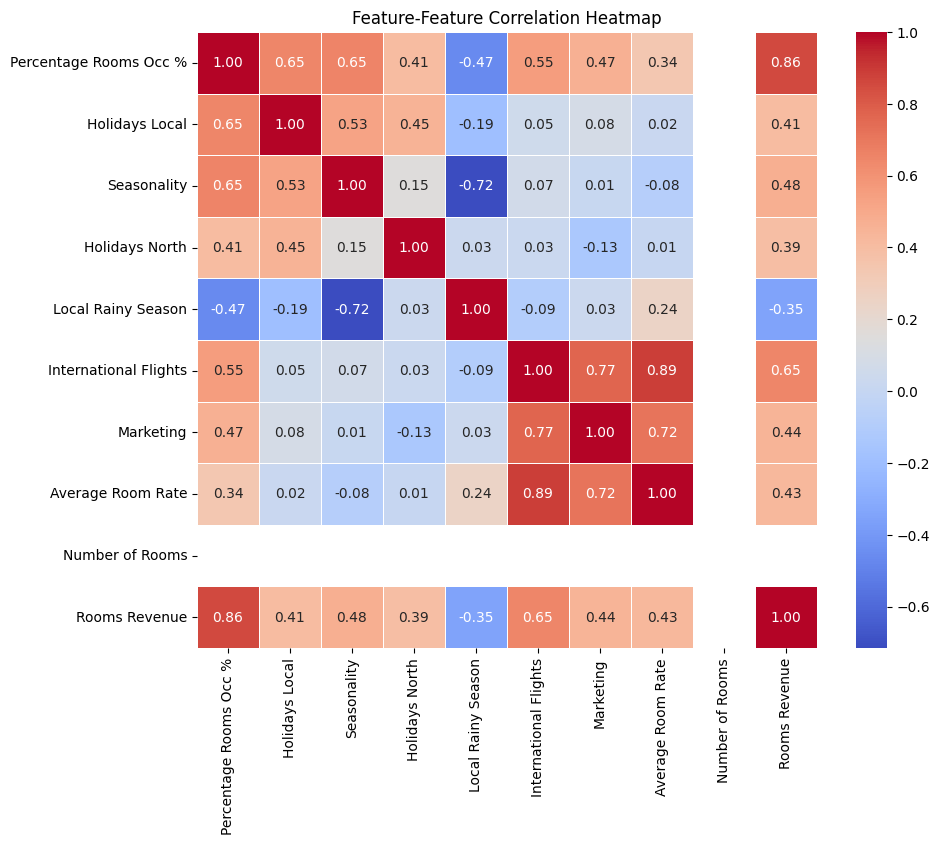

Features suggested for removal based on high feature-feature correlation:
{'Seasonality', 'Marketing', 'Percentage Rooms Occ %', 'Holidays Local', 'Local Rainy Season', 'Average Room Rate', 'International Flights'}


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing your dataset

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature-Feature Correlation Heatmap")
plt.show()

# Identify highly correlated feature pairs
highly_correlated_pairs = []
correlation_threshold = 0.6  # You can adjust this threshold as needed

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            highly_correlated_pairs.append((feature_i, feature_j))

# Suggest features for removal (keeping one from each highly correlated pair)
features_to_remove = set()
for feature1, feature2 in highly_correlated_pairs:
    # Suggest keeping the feature with higher correlation with the target variable (assuming it's "Room Revenue")
    if abs(correlation_matrix.loc[feature1, "Rooms Revenue"]) >= abs(correlation_matrix.loc[feature2, "Rooms Revenue"]):
        features_to_remove.add(feature2)
    else:
        features_to_remove.add(feature1)

print("Features suggested for removal based on high feature-feature correlation:")
print(features_to_remove)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2022-01-01 to 2023-12-01
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Percentage Rooms Occ %  24 non-null     float64
 1   Holidays Local          24 non-null     float64
 2   Seasonality             24 non-null     int64  
 3   Holidays North          24 non-null     float64
 4   Local Rainy Season      24 non-null     int64  
 5   International Flights   24 non-null     float64
 6   Marketing               24 non-null     float64
 7   Average Room Rate       24 non-null     float64
 8   Number of Rooms         24 non-null     float64
 9   Rooms Revenue           24 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 2.1 KB


### Coefficients work with Linear Regression

In [24]:
def linear_model_coefficients(model, columns):
    print(f"* Intercept: {model.intercept_}")
    coeff_df = pd.DataFrame(model.coef_, columns, columns=['Coefficient']).sort_values(by='Coefficient', key=abs, ascending=False)
    print("* Coefficients")
    print(coeff_df)

In [25]:
linear_model_coefficients(model=pipeline['model'],
                          columns=X_train.columns[pipeline['feature_selection'].get_support()]  )

AttributeError: 'AdaBoostRegressor' object has no attribute 'intercept_'

### Full Analysis

In [29]:
df

,Percentage Rooms Occ %,Holidays Local,Seasonality,Holidays North,Local Rainy Season,International Flights,Marketing,Average Room Rate,Number of Rooms,Rooms Revenue
Date,,,,,,,,,,
2022-01-01,0.61,3.0,2,7.0,0,1.0,62.12,75.0,9.0,13136.89
2022-02-01,0.62,1.0,2,0.0,0,1.0,62.12,75.0,9.0,11430.53
2022-03-01,0.39,0.0,2,0.0,0,1.0,99.31,75.0,9.0,9742.62
2022-04-01,0.70,5.0,2,0.0,0,1.0,246.06,75.0,9.0,15043.81
2022-05-01,0.47,1.0,0,0.0,1,1.0,144.93,75.0,9.0,8546.17
2022-06-01,0.33,0.0,0,0.0,1,1.0,118.46,75.0,9.0,7171.42
2022-07-01,0.67,3.0,1,20.0,1,1.0,46.77,75.0,9.0,15864.98
2022-08-01,0.49,2.0,1,10.0,1,1.0,149.97,77.0,9.0,11925.83
2022-09-01,0.51,3.0,1,0.0,2,1.0,170.25,77.0,9.0,13738.03


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Rooms Revenue'], axis=1),
    df['Rooms Revenue'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(19, 9) (19,) (5, 9) (5,)


In [32]:
def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feature_scaling", StandardScaler()),
        ("feature_selection", SelectFromModel(AdaBoostRegressor(random_state=101))),
        ("model", AdaBoostRegressor(random_state=101)),
    ])
    return pipeline

In [27]:
params_grid = {"model__n_estimators": [10, 20]}
params_grid

{'model__n_estimators': [10, 20]}

In [33]:
grid = GridSearchCV(estimator=pipeline_random_forest_reg(),
                    param_grid = param_grid,
                    cv = 2,
                    n_jobs = -2,
                    verbose = 3,
                    scoring = 'r2')

grid.fit(X_train, y_train)                    

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 2/2] END ............model__n_estimators=20;, score=0.743 total time=   0.2s
[CV 1/2] END ............model__n_estimators=10;, score=0.432 total time=   0.2s
[CV 1/2] END ............model__n_estimators=20;, score=0.334 total time=   0.3s
[CV 2/2] END ............model__n_estimators=10;, score=0.825 total time=   0.3s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=AdaBoostRegressor(random_state=101))),
                                       ('model',
                                        AdaBoostRegressor(random_state=101))]),
             n_jobs=-2, param_grid={'model__n_estimators': [10, 20]},
             scoring='r2', verbose=3)

In [34]:
grid.cv_results_

{'mean_fit_time': array([0.2409426, 0.1904428]),
 'std_fit_time': array([0.03212392, 0.00905156]),
 'mean_score_time': array([0.00591254, 0.03283083]),
 'std_score_time': array([0.00101471, 0.02695525]),
 'param_model__n_estimators': masked_array(data=[10, 20],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__n_estimators': 10}, {'model__n_estimators': 20}],
 'split0_test_score': array([0.43167257, 0.33383312]),
 'split1_test_score': array([0.82519848, 0.74266024]),
 'mean_test_score': array([0.62843553, 0.53824668]),
 'std_test_score': array([0.19676296, 0.20441356]),
 'rank_test_score': array([1, 2], dtype=int32)}

In [19]:
(pd.DataFrame(grid.cv_results_)
.sort_values(by="mean_test_score", ascending=False)
.filter(['params', 'mean_test_score'])
.values
)

array([[{'model__n_estimators': 20}, 0.6687932807992871],
       [{'model__n_estimators': 10}, 0.6669936945631451]], dtype=object)

In [35]:
grid.best_params_

{'model__n_estimators': 10}

In [36]:
pipeline = grid.best_estimator_
pipeline

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=AdaBoostRegressor(random_state=101))),
                ('model',
                 AdaBoostRegressor(n_estimators=10, random_state=101))])

In [37]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")
    
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")
    
    plt.show()


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2022-01-01 to 2023-12-01
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Percentage Rooms Occ %  24 non-null     float64
 1   Holidays Local          24 non-null     float64
 2   Seasonality             24 non-null     int64  
 3   Holidays North          24 non-null     float64
 4   Local Rainy Season      24 non-null     int64  
 5   International Flights   24 non-null     float64
 6   Marketing               24 non-null     float64
 7   Average Room Rate       24 non-null     float64
 8   Number of Rooms         24 non-null     float64
 9   Rooms Revenue           24 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 2.1 KB


Model Evaluation
* Train Set
R2 Score: 0.97
Mean Absolute Error: 461.82
Mean Squared Error: 461485.32
Root Mean Squared Error: 679.327


* Test Set
R2 Score: -0.575
Mean Absolute Error: 2159.954
Mean Squared Error: 9273966.116
Root Mean Squared Error: 3045.319




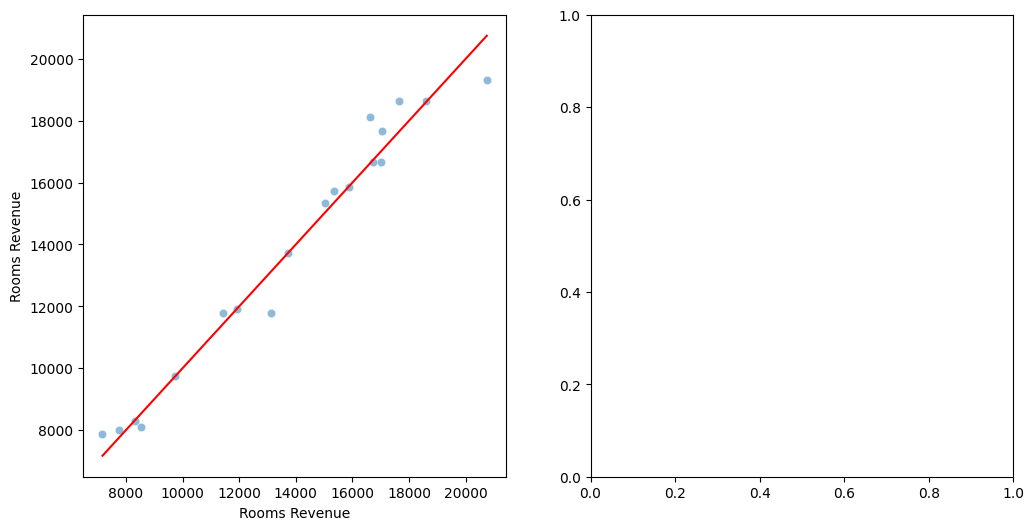

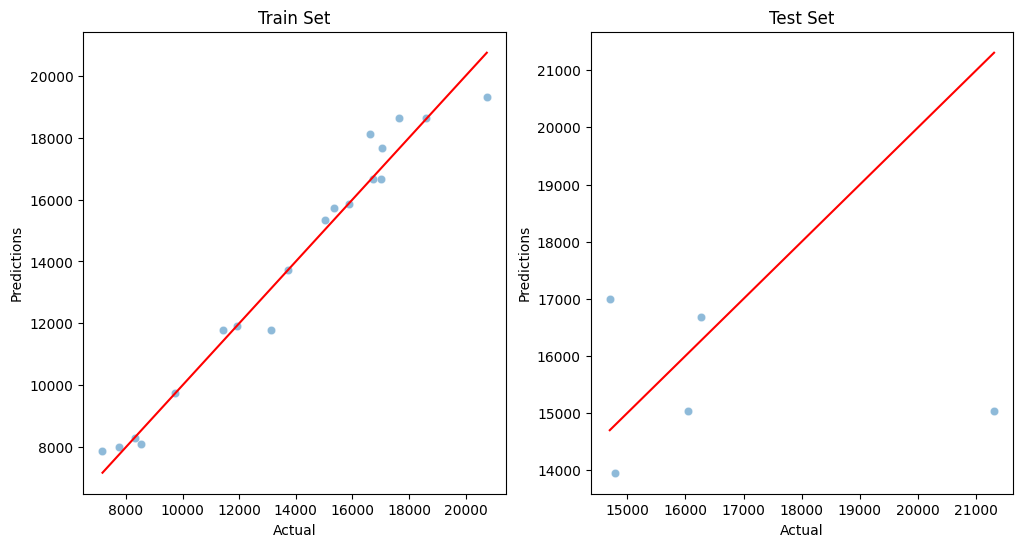

In [38]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)

In [99]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


(19, 9) (19,) (5, 9) (5,)
